## Import Library & Data

In [1]:
import pandas as pd
data_df = pd.read_csv('../Output/PubMed_CleanArticles_Top1-10_cancerTypes.csv', encoding='utf-8')
data_df = data_df[['Article', 'Clean Article', 'Target Label', 'Target Name']]
data_df.head(10)

,Article,Clean Article,Target Label,Target Name
0,Understanding the symptoms experienced by indi...,understand symptom experience individual lung ...,1,Lung
1,Do statins improve outcomes for patients with ...,statin improve outcome patient non small cell ...,1,Lung
2,"Lung cancer epidemiology, risk factors, and pr...",lung cancer epidemiology risk factor preventio...,1,Lung
3,[Modern Nanomedicine in Treatment of Lung Carc...,modern nanomedicine treatment lung carcinomas ...,1,Lung
4,[Nineteen multiple primary cancer cases of 100...,nineteen multiple primary cancer case patient ...,1,Lung
5,Image-guided radiotherapy and motion managemen...,image guide radiotherapy motion management lun...,1,Lung
6,[III. Immune Checkpoint Inhibitor as a Standar...,iii immune checkpoint inhibitor standard treat...,1,Lung
7,Radiotherapy for small-cell lung cancer-Where ...,radiotherapy small cell lung cancer head radio...,1,Lung
8,Coagulation-fibrinolytic analysis in patients ...,coagulation fibrinolytic analysis patient lung...,1,Lung
9,Revisiting the debate: the use of new agents i...,revisit debate use new agent previously untrea...,1,Lung


In [2]:
data_labels_map = dict(enumerate(pd.unique(data_df['Target Name'])))
data_labels_map

{0: 'Lung',
 1: 'Breast',
 2: 'Colorectal',
 3: 'Prostate',
 4: 'Stomach',
 5: 'Liver',
 6: 'Oesophagus',
 7: 'Cervix Uteri',
 8: 'Thyroid',
 9: 'Bladder'}

## Split Data into Train & Test

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(data_df['Clean Article']), np.array(data_df['Target Label']),
                                                       np.array(data_df['Target Name']), test_size=0.33, random_state=42)

train_corpus.shape, test_corpus.shape

((6700,), (3300,))

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)
# transform test articles into features
tv_test_features = tv.transform(test_corpus)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (6700, 20634)  Test features shape: (3300, 20634)


## Grid Search CV

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

### Naive Bayes

In [6]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.7s finished


In [7]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('mnb', MultinomialNB(alpha=1))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'mnb': MultinomialNB(alpha=1),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'mnb__alpha': 1,
 'mnb__class_prior': None,
 'mnb__fit_prior': True}

In [8]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
9,1,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.975821,0.001537
7,2,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}",0.953731,0.006026
8,3,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 1)}",0.947015,0.004882
5,4,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}",0.928955,0.004959
6,5,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",0.904627,0.008126
3,6,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",0.889851,0.008530
1,7,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.876716,0.007409
4,8,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 1)}",0.865821,0.007718
2,9,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",0.808209,0.007048
0,10,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",0.784179,0.006895


In [9]:
best_mnb_test_score = gs_mnb.score(test_corpus, test_label_names)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.9745454545454545


In [10]:
nb_param = results_df.iloc[0]['params']
nb_cvmean = results_df.iloc[0]['cv score (mean)']
nb_cvstd = results_df.iloc[0]['cv score (std)']
nb_acc = best_mnb_test_score
print(nb_param, nb_cvmean, nb_cvstd, nb_acc)

{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)} 0.975820895522388 0.0015366612150726777 0.9745454545454545


### Linear Regression

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished
C:\ANACONDA\envs\jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
gs_lr.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=10, random_state=42))])

In [13]:
lr_results = gs_lr.cv_results_
results_df = pd.DataFrame({'rank': lr_results['rank_test_score'],
                           'params': lr_results['params'], 
                           'cv score (mean)': lr_results['mean_test_score'], 
                           'cv score (std)': lr_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'lr__C': 10, 'tfidf__ngram_range': (1, 2)}",0.987463,0.001522
3,2,"{'lr__C': 5, 'tfidf__ngram_range': (1, 2)}",0.987164,0.001194
1,3,"{'lr__C': 1, 'tfidf__ngram_range': (1, 2)}",0.987164,0.001447
4,4,"{'lr__C': 10, 'tfidf__ngram_range': (1, 1)}",0.985821,0.002670
2,5,"{'lr__C': 5, 'tfidf__ngram_range': (1, 1)}",0.985522,0.002341
0,6,"{'lr__C': 1, 'tfidf__ngram_range': (1, 1)}",0.985224,0.002132


In [14]:
best_lr_test_score = gs_lr.score(test_corpus, test_label_names)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.9890909090909091


In [15]:
lr_param = results_df.iloc[0]['params']
lr_cvmean = results_df.iloc[0]['cv score (mean)']
lr_cvstd = results_df.iloc[0]['cv score (std)']
lr_acc = best_lr_test_score
print(lr_param, lr_cvmean, lr_cvstd, lr_acc)

{'lr__C': 10, 'tfidf__ngram_range': (1, 2)} 0.9874626865671642 0.00152209537719187 0.9890909090909091


### Linear SVM

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   30.6s finished


In [17]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=1, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=1, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 1,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

In [18]:
svm_results = gs_svm.cv_results_
results_df = pd.DataFrame({'rank': svm_results['rank_test_score'],
                           'params': svm_results['params'], 
                           'cv score (mean)': svm_results['mean_test_score'], 
                           'cv score (std)': svm_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'svm__C': 1, 'tfidf__ngram_range': (1, 2)}",0.988209,0.001969
7,2,"{'svm__C': 5, 'tfidf__ngram_range': (1, 2)}",0.987910,0.001969
3,3,"{'svm__C': 0.1, 'tfidf__ngram_range': (1, 2)}",0.986866,0.002244
2,4,"{'svm__C': 0.1, 'tfidf__ngram_range': (1, 1)}",0.986119,0.001301
4,5,"{'svm__C': 1, 'tfidf__ngram_range': (1, 1)}",0.986119,0.001741
6,6,"{'svm__C': 5, 'tfidf__ngram_range': (1, 1)}",0.985672,0.002379
1,7,"{'svm__C': 0.01, 'tfidf__ngram_range': (1, 2)}",0.983881,0.002695
0,8,"{'svm__C': 0.01, 'tfidf__ngram_range': (1, 1)}",0.982388,0.003007


In [19]:
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.9881818181818182


In [20]:
svm_param = results_df.iloc[0]['params']
svm_cvmean = results_df.iloc[0]['cv score (mean)']
svm_cvstd = results_df.iloc[0]['cv score (std)']
svm_acc = best_svm_test_score
print(svm_param, svm_cvmean, svm_cvstd, svm_acc)

{'svm__C': 1, 'tfidf__ngram_range': (1, 2)} 0.9882089552238806 0.0019687919340706014 0.9881818181818182


### SGD

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_sgd = gs_sgd.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.7s finished


In [22]:
gs_sgd.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('sgd', SGDClassifier(alpha=1e-05, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'sgd': SGDClassifier(alpha=1e-05, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'sgd__alpha': 1e-05,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0

In [23]:
sgd_results = gs_sgd.cv_results_
results_df = pd.DataFrame({'rank': sgd_results['rank_test_score'],
                           'params': sgd_results['params'], 
                           'cv score (mean)': sgd_results['mean_test_score'], 
                           'cv score (std)': sgd_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'sgd__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.988209,0.002471
7,2,"{'sgd__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",0.987910,0.001594
6,3,"{'sgd__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",0.986418,0.002559
3,4,"{'sgd__alpha': 1e-06, 'tfidf__ngram_range': (1, 2)}",0.985821,0.001335
4,5,"{'sgd__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",0.985075,0.002792
1,6,"{'sgd__alpha': 1e-07, 'tfidf__ngram_range': (1, 2)}",0.983881,0.002568
2,7,"{'sgd__alpha': 1e-06, 'tfidf__ngram_range': (1, 1)}",0.982239,0.003576
0,8,"{'sgd__alpha': 1e-07, 'tfidf__ngram_range': (1, 1)}",0.977313,0.002611


In [24]:
best_sgd_test_score = gs_sgd.score(test_corpus, test_label_names)
print('Test Accuracy :', best_sgd_test_score)

Test Accuracy : 0.9878787878787879


In [25]:
sgd_param = results_df.iloc[0]['params']
sgd_cvmean = results_df.iloc[0]['cv score (mean)']
sgd_cvstd = results_df.iloc[0]['cv score (std)']
sgd_acc = best_sgd_test_score
print(sgd_param, sgd_cvmean, sgd_cvstd, sgd_acc)

{'sgd__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)} 0.9882089552238806 0.002470588859290571 0.9878787878787879


### Random Forest

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

rf_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('rf', RandomForestClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'rf__max_depth': [80, 90, 100, 110],
              'rf__n_estimators': [10, 20, 50, 100]
#               'rf__min_samples_leaf': [3, 4, 5],
#               'rf__min_samples_split': [8, 10, 12],
              
              
              
}

gs_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_rf = gs_rf.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.9min finished


In [27]:
gs_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('rf', RandomForestClassifier(max_depth=100, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'rf': RandomForestClassifier(max_depth=100, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': 100,
 'rf__max_features': 'auto',
 'rf__ma

In [28]:
rf_results = gs_rf.cv_results_
results_df = pd.DataFrame({'rank': rf_results['rank_test_score'],
                           'params': rf_results['params'], 
                           'cv score (mean)': rf_results['mean_test_score'], 
                           'cv score (std)': rf_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
22,1,"{'rf__max_depth': 100, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.984776,0.001923
7,2,"{'rf__max_depth': 80, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 2)}",0.984328,0.002985
6,3,"{'rf__max_depth': 80, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.983881,0.001012
23,4,"{'rf__max_depth': 100, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 2)}",0.983731,0.002283
31,5,"{'rf__max_depth': 110, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 2)}",0.983582,0.002909
14,6,"{'rf__max_depth': 90, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.983134,0.002036
30,7,"{'rf__max_depth': 110, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.982687,0.001447
15,8,"{'rf__max_depth': 90, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 2)}",0.982239,0.003284
29,9,"{'rf__max_depth': 110, 'rf__n_estimators': 50, 'tfidf__ngram_range': (1, 2)}",0.981791,0.001384
5,10,"{'rf__max_depth': 80, 'rf__n_estimators': 50, 'tfidf__ngram_range': (1, 2)}",0.981493,0.001852


In [29]:
best_rf_test_score = gs_rf.score(test_corpus, test_label_names)
print('Test Accuracy :', best_rf_test_score)

Test Accuracy : 0.9821212121212122


In [30]:
rf_param = results_df.iloc[0]['params']
rf_cvmean = results_df.iloc[0]['cv score (mean)']
rf_cvstd = results_df.iloc[0]['cv score (std)']
rf_acc = best_rf_test_score
print(rf_param, rf_cvmean, rf_cvstd, rf_acc)

{'rf__max_depth': 100, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)} 0.984776119402985 0.001922999809958955 0.9821212121212122


### Gradient Boosted Machines

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

gbm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('gbm', GradientBoostingClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'gbm__min_samples_split': [2, 3],
              'gbm__max_depth': [3, 4],
}

gbm_rf = GridSearchCV(gbm_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gbm_rf = gbm_rf.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 62.6min finished


In [32]:
gbm_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('gbm', GradientBoostingClassifier(max_depth=4, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'gbm': GradientBoostingClassifier(max_depth=4, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'gbm__ccp_alpha': 0.0,
 'gbm__criterion': 'friedman_mse',
 'gbm__init': None,
 'gbm__learning_rate': 0.1,
 'gbm__loss

In [33]:
gbm_results = gbm_rf.cv_results_
results_df = pd.DataFrame({'rank': gbm_results['rank_test_score'],
                           'params': gbm_results['params'], 
                           'cv score (mean)': gbm_results['mean_test_score'], 
                           'cv score (std)': gbm_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.981194,0.004179
2,2,"{'gbm__max_depth': 3, 'gbm__min_samples_split': 3, 'tfidf__ngram_range': (1, 1)}",0.980746,0.003351
0,3,"{'gbm__max_depth': 3, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 1)}",0.980597,0.003776
7,3,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 3, 'tfidf__ngram_range': (1, 2)}",0.980597,0.005277
1,5,"{'gbm__max_depth': 3, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.980149,0.005183
4,6,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 1)}",0.980000,0.003215
6,7,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 3, 'tfidf__ngram_range': (1, 1)}",0.979701,0.003576
3,8,"{'gbm__max_depth': 3, 'gbm__min_samples_split': 3, 'tfidf__ngram_range': (1, 2)}",0.979552,0.005226


In [34]:
best_gbm_test_score = gbm_rf.score(test_corpus, test_label_names)
print('Test Accuracy :', best_gbm_test_score)

Test Accuracy : 0.9815151515151516


In [35]:
gbm_param = results_df.iloc[0]['params']
gbm_cvmean = results_df.iloc[0]['cv score (mean)']
gbm_cvstd = results_df.iloc[0]['cv score (std)']
gbm_acc = best_gbm_test_score
print(gbm_param, gbm_cvmean, gbm_cvstd, gbm_acc)

{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)} 0.9811940298507462 0.004179104477611924 0.9815151515151516


In [37]:
recap = pd.DataFrame([['Naive Bayes', 
               nb_param, nb_cvmean, nb_cvstd, nb_acc],
              ['Logistic Regression', 
               lr_param, lr_cvmean, lr_cvstd, lr_acc],
              ['Linear SVM', 
               svm_param, svm_cvmean, svm_cvstd, svm_acc],
              ['Linear SVM (SGD)',  
               sgd_param, sgd_cvmean, sgd_cvstd, sgd_acc],
              ['Random Forest', 
               rf_param, rf_cvmean, rf_cvstd, rf_acc],
              ['Gradient Boosted Machines', 
               gbm_param, gbm_cvmean, gbm_cvstd, gbm_acc]],
             columns=['Model', 'Params', 'CV Score (Mean)', 'CV Score (Std)','Test Accuracy'],
             )
recap.to_csv('tuning_gridcv.csv',index=False)
recap

,Model,Params,CV Score (Mean),CV Score (Std),Test Accuracy
0,Naive Bayes,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.975821,0.001537,0.974545
1,Logistic Regression,"{'lr__C': 10, 'tfidf__ngram_range': (1, 2)}",0.987463,0.001522,0.989091
2,Linear SVM,"{'svm__C': 1, 'tfidf__ngram_range': (1, 2)}",0.988209,0.001969,0.988182
3,Linear SVM (SGD),"{'sgd__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.988209,0.002471,0.987879
4,Random Forest,"{'rf__max_depth': 100, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.984776,0.001923,0.982121
5,Gradient Boosted Machines,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.981194,0.004179,0.981515


## Random Search CV

In [38]:
from sklearn.model_selection import RandomizedSearchCV

### Naive Bayes

In [39]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = RandomizedSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.6s finished


In [40]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('mnb', MultinomialNB(alpha=1))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'mnb': MultinomialNB(alpha=1),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'mnb__alpha': 1,
 'mnb__class_prior': None,
 'mnb__fit_prior': True}

In [41]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
9,1,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1}",0.975821,0.001537
7,2,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.1}",0.953731,0.006026
8,3,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 1}",0.947015,0.004882
5,4,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.01}",0.928955,0.004959
6,5,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.1}",0.904627,0.008126
3,6,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.0001}",0.889851,0.008530
1,7,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1e-05}",0.876716,0.007409
4,8,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.01}",0.865821,0.007718
2,9,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.0001}",0.808209,0.007048
0,10,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 1e-05}",0.784179,0.006895


In [42]:
best_mnb_test_score = gs_mnb.score(test_corpus, test_label_names)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.9745454545454545


In [43]:
nb_param = results_df.iloc[0]['params']
nb_cvmean = results_df.iloc[0]['cv score (mean)']
nb_cvstd = results_df.iloc[0]['cv score (std)']
nb_acc = best_mnb_test_score
print(nb_param, nb_cvmean, nb_cvstd, nb_acc)

{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1} 0.975820895522388 0.0015366612150726777 0.9745454545454545


### Linear Regression

In [44]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = RandomizedSearchCV(lr_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

C:\ANACONDA\envs\jupyter\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished
C:\ANACONDA\envs\jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [45]:
gs_lr.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=10, random_state=42))])

In [46]:
lr_results = gs_lr.cv_results_
results_df = pd.DataFrame({'rank': lr_results['rank_test_score'],
                           'params': lr_results['params'], 
                           'cv score (mean)': lr_results['mean_test_score'], 
                           'cv score (std)': lr_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'tfidf__ngram_range': (1, 2), 'lr__C': 10}",0.987463,0.001522
3,2,"{'tfidf__ngram_range': (1, 2), 'lr__C': 5}",0.987164,0.001194
1,3,"{'tfidf__ngram_range': (1, 2), 'lr__C': 1}",0.987164,0.001447
4,4,"{'tfidf__ngram_range': (1, 1), 'lr__C': 10}",0.985821,0.002670
2,5,"{'tfidf__ngram_range': (1, 1), 'lr__C': 5}",0.985522,0.002341
0,6,"{'tfidf__ngram_range': (1, 1), 'lr__C': 1}",0.985224,0.002132


In [47]:
best_lr_test_score = gs_lr.score(test_corpus, test_label_names)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.9890909090909091


In [48]:
lr_param = results_df.iloc[0]['params']
lr_cvmean = results_df.iloc[0]['cv score (mean)']
lr_cvstd = results_df.iloc[0]['cv score (std)']
lr_acc = best_lr_test_score
print(lr_param, lr_cvmean, lr_cvstd, lr_acc)

{'tfidf__ngram_range': (1, 2), 'lr__C': 10} 0.9874626865671642 0.00152209537719187 0.9890909090909091


### Linear SVM

In [61]:
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = RandomizedSearchCV(svm_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

C:\ANACONDA\envs\jupyter\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.3s finished


In [62]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=1, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=1, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 1,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

In [63]:
svm_results = gs_svm.cv_results_
results_df = pd.DataFrame({'rank': svm_results['rank_test_score'],
                           'params': svm_results['params'], 
                           'cv score (mean)': svm_results['mean_test_score'], 
                           'cv score (std)': svm_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'tfidf__ngram_range': (1, 2), 'svm__C': 1}",0.988209,0.001969
7,2,"{'tfidf__ngram_range': (1, 2), 'svm__C': 5}",0.987910,0.001969
3,3,"{'tfidf__ngram_range': (1, 2), 'svm__C': 0.1}",0.986866,0.002244
2,4,"{'tfidf__ngram_range': (1, 1), 'svm__C': 0.1}",0.986119,0.001301
4,5,"{'tfidf__ngram_range': (1, 1), 'svm__C': 1}",0.986119,0.001741
6,6,"{'tfidf__ngram_range': (1, 1), 'svm__C': 5}",0.985672,0.002379
1,7,"{'tfidf__ngram_range': (1, 2), 'svm__C': 0.01}",0.983881,0.002695
0,8,"{'tfidf__ngram_range': (1, 1), 'svm__C': 0.01}",0.982388,0.003007


In [64]:
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.9881818181818182


In [65]:
svm_param = results_df.iloc[0]['params']
svm_cvmean = results_df.iloc[0]['cv score (mean)']
svm_cvstd = results_df.iloc[0]['cv score (std)']
svm_acc = best_svm_test_score
print(svm_param, svm_cvmean, svm_cvstd, svm_acc)

{'tfidf__ngram_range': (1, 2), 'svm__C': 1} 0.9882089552238806 0.0019687919340706014 0.9881818181818182


### SGD

In [66]:
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = RandomizedSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_sgd = gs_sgd.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\ANACONDA\envs\jupyter\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.8s finished


In [67]:
gs_sgd.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('sgd', SGDClassifier(alpha=1e-05, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'sgd': SGDClassifier(alpha=1e-05, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'sgd__alpha': 1e-05,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0

In [68]:
sgd_results = gs_sgd.cv_results_
results_df = pd.DataFrame({'rank': sgd_results['rank_test_score'],
                           'params': sgd_results['params'], 
                           'cv score (mean)': sgd_results['mean_test_score'], 
                           'cv score (std)': sgd_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
5,1,"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-05}",0.988209,0.002471
7,2,"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 0.0001}",0.987910,0.001594
6,3,"{'tfidf__ngram_range': (1, 1), 'sgd__alpha': 0.0001}",0.986418,0.002559
3,4,"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-06}",0.985821,0.001335
4,5,"{'tfidf__ngram_range': (1, 1), 'sgd__alpha': 1e-05}",0.985075,0.002792
1,6,"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-07}",0.983881,0.002568
2,7,"{'tfidf__ngram_range': (1, 1), 'sgd__alpha': 1e-06}",0.982239,0.003576
0,8,"{'tfidf__ngram_range': (1, 1), 'sgd__alpha': 1e-07}",0.977313,0.002611


In [69]:
best_sgd_test_score = gs_sgd.score(test_corpus, test_label_names)
print('Test Accuracy :', best_sgd_test_score)

Test Accuracy : 0.9878787878787879


In [70]:
sgd_param = results_df.iloc[0]['params']
sgd_cvmean = results_df.iloc[0]['cv score (mean)']
sgd_cvstd = results_df.iloc[0]['cv score (std)']
sgd_acc = best_sgd_test_score
print(sgd_param, sgd_cvmean, sgd_cvstd, sgd_acc)

{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-05} 0.9882089552238806 0.002470588859290571 0.9878787878787879


### Random Forest

In [71]:
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

rf_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('rf', RandomForestClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'rf__max_depth': [80, 90, 100, 110],
              'rf__n_estimators': [10, 20, 50, 100]
#               'rf__min_samples_leaf': [3, 4, 5],
#               'rf__min_samples_split': [8, 10, 12],
              
              
              
}

gs_rf = RandomizedSearchCV(rf_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_rf = gs_rf.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.4s finished


In [72]:
gs_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('rf', RandomForestClassifier(max_depth=100, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'rf': RandomForestClassifier(max_depth=100, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': 100,
 'rf__max_features': 'auto',
 'rf__ma

In [73]:
rf_results = gs_rf.cv_results_
results_df = pd.DataFrame({'rank': rf_results['rank_test_score'],
                           'params': rf_results['params'], 
                           'cv score (mean)': rf_results['mean_test_score'], 
                           'cv score (std)': rf_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
4,1,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 100}",0.984776,0.001923
0,2,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 90}",0.983134,0.002036
3,3,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 110}",0.982687,0.001447
1,4,"{'tfidf__ngram_range': (1, 2), 'rf__n_estimators': 50, 'rf__max_depth': 100}",0.981194,0.003073
7,5,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 50, 'rf__max_depth': 100}",0.980000,0.002379
9,6,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 50, 'rf__max_depth': 110}",0.979851,0.003746
2,7,"{'tfidf__ngram_range': (1, 2), 'rf__n_estimators': 20, 'rf__max_depth': 80}",0.969552,0.003638
6,8,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 20, 'rf__max_depth': 90}",0.964030,0.009780
8,9,"{'tfidf__ngram_range': (1, 2), 'rf__n_estimators': 10, 'rf__max_depth': 100}",0.931791,0.007678
5,10,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 10, 'rf__max_depth': 110}",0.924328,0.013263


In [74]:
best_rf_test_score = gs_rf.score(test_corpus, test_label_names)
print('Test Accuracy :', best_rf_test_score)

Test Accuracy : 0.9821212121212122


In [75]:
rf_param = results_df.iloc[0]['params']
rf_cvmean = results_df.iloc[0]['cv score (mean)']
rf_cvstd = results_df.iloc[0]['cv score (std)']
rf_acc = best_rf_test_score
print(rf_param, rf_cvmean, rf_cvstd, rf_acc)

{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 100} 0.984776119402985 0.001922999809958955 0.9821212121212122


In [76]:
recap_random = pd.DataFrame([['Naive Bayes', 
               nb_param, nb_cvmean, nb_cvstd, nb_acc],
              ['Logistic Regression', 
               lr_param, lr_cvmean, lr_cvstd, lr_acc],
              ['Linear SVM', 
               svm_param, svm_cvmean, svm_cvstd, svm_acc],
              ['Linear SVM (SGD)',  
               sgd_param, sgd_cvmean, sgd_cvstd, sgd_acc],
              ['Random Forest', 
               rf_param, rf_cvmean, rf_cvstd, rf_acc],
              ['Gradient Boosted Machines', 
               gbm_param, gbm_cvmean, gbm_cvstd, gbm_acc]],
             columns=['Model', 'Params', 'CV Score (Mean)', 'CV Score (Std)','Test Accuracy'],
             )
recap_random.to_csv('tuning_randomcv.csv',index=False)
recap_random

,Model,Params,CV Score (Mean),CV Score (Std),Test Accuracy
0,Naive Bayes,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1}",0.975821,0.001537,0.974545
1,Logistic Regression,"{'tfidf__ngram_range': (1, 2), 'lr__C': 10}",0.987463,0.001522,0.989091
2,Linear SVM,"{'tfidf__ngram_range': (1, 2), 'svm__C': 1}",0.988209,0.001969,0.988182
3,Linear SVM (SGD),"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-05}",0.988209,0.002471,0.987879
4,Random Forest,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 100}",0.984776,0.001923,0.982121
5,Gradient Boosted Machines,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.981194,0.004179,0.981515


## Evaluate (Accuracy, Precision, Recall, F1-Score)

In [77]:
import model_evaluation_utils as meu
mnb_predictions = gs_lr.predict(test_corpus)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=mnb_predictions)

Accuracy: 0.9891
Precision: 0.9891
Recall: 0.9891
F1 Score: 0.9891


In [78]:
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=mnb_predictions, classes=unique_classes)

              precision    recall  f1-score   support

     Thyroid       1.00      1.00      1.00       353
     Stomach       0.98      0.99      0.98       351
     Bladder       0.99      0.99      0.99       307
    Prostate       0.99      0.99      0.99       332
  Oesophagus       0.98      0.98      0.98       319
  Colorectal       0.99      0.97      0.98       315
      Breast       1.00      1.00      1.00       335
        Lung       0.99      0.99      0.99       345
       Liver       0.98      0.97      0.98       323
Cervix Uteri       0.98      0.99      0.99       320

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



In [79]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,Lung,0
1,Breast,1
2,Colorectal,2
3,Prostate,3
4,Stomach,4
5,Liver,5
6,Oesophagus,6
7,Cervix Uteri,7
8,Thyroid,8
9,Bladder,9


In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

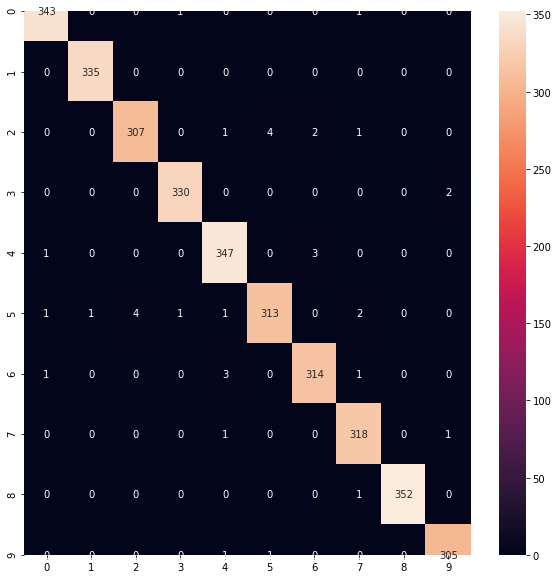

In [83]:
cm1 = confusion_matrix(test_label_names, mnb_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

## Testing Predicted Data

In [84]:
train_idx, test_idx = train_test_split(np.array(range(len(data_df['Article']))), test_size=0.33, random_state=42)
test_idx

array([6252, 4684, 1731, ..., 6094, 8781, 9401])

In [85]:
predict_probas = gs_lr.predict_proba(test_corpus).max(axis=1)
test_df = data_df.iloc[test_idx]
test_df['Predicted Name'] = mnb_predictions
test_df['Predicted Confidence'] = predict_probas
test_df.head()

C:\Users\Bastian Farandy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Bastian Farandy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Article,Clean Article,Target Label,Target Name,Predicted Name,Predicted Confidence
6252,Preoperative chemoradiotherapy for locoregional esophageal cancer: preliminary report. Conventio...,preoperative chemoradiotherapy locoregional esophageal cancer preliminary report conventional tr...,7,Oesophagus,Oesophagus,0.979169
4684,[Cytologic diagnosis of stomach cancer by the fluorescent method using acridine orange and ethyl...,cytologic diagnosis stomach cancer fluorescent method use acridine orange ethyl acridine orange ...,5,Stomach,Stomach,0.889676
1731,[Breast cancer]. INTRODUCTION AND AIM: Male breast cancer (MBC) is a rare disease which represen...,breast cancer introduction aim male breast cancer mbc rare disease represent cancer ratio female...,2,Breast,Breast,0.993291
4742,The effects of genomic polymorphisms in one-carbon metabolism pathways on survival of gastric ca...,effect genomic polymorphism one carbon metabolism pathway survival gastric cancer patient receiv...,5,Stomach,Stomach,0.749680
4521,Molecular screening of gastric cancer by proteome analysis. Gastric cancer affects annually more...,molecular screening gastric cancer proteome analysis gastric cancer affect annually individual w...,5,Stomach,Stomach,0.999555


In [86]:
pd.set_option('display.max_colwidth', 200)
res_df = (test_df[(test_df['Target Name'] != test_df['Predicted Name'])]
       .sort_values(by=['Predicted Confidence'], ascending=False).head(5))
res_df

,Article,Clean Article,Target Label,Target Name,Predicted Name,Predicted Confidence
2960,Demographic factors and health coverage affect colorectal cancer treatment in the state of Washington. AIMS: The existence of other primary tumors during the treatment of esophageal cancer patient...,demographic factor health coverage affect colorectal cancer treatment state washington aim existence primary tumor treatment esophageal cancer patient important issue aim investigate prevalence ma...,3,Colorectal,Oesophagus,0.991525
5226,[Colorectal cancers: management of metastatic cancers]. Close to half of patients suffering from colorectal cancer develop metastases. Their natural prognosis is grim with a median survival of 6 t...,colorectal cancer management metastatic cancer close half patient suffer colorectal cancer develop metastasis natural prognosis grim median survival month current treatment option rest surgery che...,6,Liver,Colorectal,0.991412
5381,Metastatic lobular breast cancer presenting with malignant ascites: case report and review of literature. We review the case of an elderly woman with invasive lobular breast cancer presenting as m...,metastatic lobular breast cancer present malignant ascite case report review literature review case elderly woman invasive lobular breast cancer present malignant ascite unusual presentation discu...,6,Liver,Breast,0.989896
462,Endobronchial metastasis from prostate cancer mimicking primary lung cancer. Endobronchial metastasis from prostate cancer is a rare neoplasm which metastasizes to the proximal central or subsegme...,endobronchial metastasis prostate cancer mimic primary lung cancer endobronchial metastasis prostate cancer rare neoplasm metastasize proximal central subsegmental bronchu bronchoscopically visibl...,1,Lung,Prostate,0.987066
4226,"Surgery and current management for cancer of the esophagus and cardia. The current status of carcinoma of the esophagus is reviewed, with specific discussions on current problems. These are diffic...",surgery current management cancer esophagus cardia current status carcinoma esophagus review specific discussion current problem difficulty stage disease confusion classification surgery vs radiat...,5,Stomach,Oesophagus,0.980462


## Recap Models Grid Search CV & Random Search CV Hyperparameter Tunning

### Grid Search CV

In [88]:
recap

,Model,Params,CV Score (Mean),CV Score (Std),Test Accuracy
0,Naive Bayes,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.975821,0.001537,0.974545
1,Logistic Regression,"{'lr__C': 10, 'tfidf__ngram_range': (1, 2)}",0.987463,0.001522,0.989091
2,Linear SVM,"{'svm__C': 1, 'tfidf__ngram_range': (1, 2)}",0.988209,0.001969,0.988182
3,Linear SVM (SGD),"{'sgd__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.988209,0.002471,0.987879
4,Random Forest,"{'rf__max_depth': 100, 'rf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}",0.984776,0.001923,0.982121
5,Gradient Boosted Machines,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.981194,0.004179,0.981515


### Random Search CV

In [89]:
recap_random

,Model,Params,CV Score (Mean),CV Score (Std),Test Accuracy
0,Naive Bayes,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1}",0.975821,0.001537,0.974545
1,Logistic Regression,"{'tfidf__ngram_range': (1, 2), 'lr__C': 10}",0.987463,0.001522,0.989091
2,Linear SVM,"{'tfidf__ngram_range': (1, 2), 'svm__C': 1}",0.988209,0.001969,0.988182
3,Linear SVM (SGD),"{'tfidf__ngram_range': (1, 2), 'sgd__alpha': 1e-05}",0.988209,0.002471,0.987879
4,Random Forest,"{'tfidf__ngram_range': (1, 1), 'rf__n_estimators': 100, 'rf__max_depth': 100}",0.984776,0.001923,0.982121
5,Gradient Boosted Machines,"{'gbm__max_depth': 4, 'gbm__min_samples_split': 2, 'tfidf__ngram_range': (1, 2)}",0.981194,0.004179,0.981515
